<a href="https://colab.research.google.com/github/RERobbins/data_science_266_sandbox/blob/main/Vector_Databases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## OpenAI and Cohere Accounts and API Endpoints

OpenAI and Cohere provide large language models.  This notebook uses API endpoints from each.  

OpenAI provides free, rate-limited usage to its API endpoint for a three-month trial period.  In order to use the OpenAI API endpoint you will need an OpenAI API token.

Cohere provides free, rate-limited usage for learning and prototyping. In order to use Cohere you will need a Cohere API token.

If you don't already have an OpenAI API token you can get one by signing up for a free OpenAI account from the [OpenAI Signup page](https://platform.openai.com/signup?launch).  Once you have created your OpenAI account you can create a trial API key from the [OpenAI API page](https://platform.openai.com/account/api-keys).

If you don't already have a Cohere API token you can get one by signing up for a Cohere account from the [Cohere dashboard](https://dashboard.cohere.ai).  Once you have created your Cohere account you can create a trial API key from the [Cohere API Keys page](https://dashboard.cohere.ai/api-keys).

## Environment Related Helpers

This portion of the notebook includes `install_if_needed` which will install a single package or list of packages with `pip` only if necessary, and `running_in_colab` a predicate that returns `True` if the notebook is running in Google Colab.

In [ ]:
import importlib


def install_if_needed(package_names):
    """
    Install one or more Python packages using pip if they are not already installed.

    Args:
        package_names (str or list): The name(s) of the package(s) to install.

    Returns:
        None
    """
    if isinstance(package_names, str):
        package_names = [package_names]

    for package_name in package_names:
        try:
            importlib.import_module(package_name)
            print(f"{package_name} is already installed.")
        except ImportError:
            !pip install --quiet {package_name}
            print(f"{package_name} has been installed.")


def running_in_colab():
    """
    Check if the Jupyter Notebook is running in Google Colab.

    Returns:
        bool: True if running in Google Colab, False otherwise.
    """
    try:
        import google.colab

        return True
    except ImportError:
        return False

## Mount Google Drive

By default, the data you create in Google Colaboratory does not persist from session to session.  Each session runs in a virtual machine and when that machine goes away, so does your data.  If you want your data to persist, you must store it outside the virtual machine. Google Drive can be used for that purpose.  We use it later in this notebook to store the OpenAI and Cohere API keys.

In [ ]:
if running_in_colab():
    from google.colab import drive

    drive.mount("drive")

Mounted at drive


## Python-dotenv

`Python-dotenv` is a Python module that allows you to specify environment variables in traditional UNIX-like “.env” (dot-env) file within your Python project directory.

Environment variables are key-value pairs for the current user environment. They are generally set by the operating system and the current user-specific configurations.

`Python-dotenv` allows the user to work with API keys without exposing them to the outside world.

In [ ]:
install_if_needed("python-dotenv")

python-dotenv has been installed.


## Add API Keys to .env File

The format of a .env file is simple: each line contains a single key-value pair, with the key and value separated by an equal sign (=). Here's an example:
```
DATABASE_URL=your_database_url
API_KEY=your_api_key
DEBUG=True
```
To use OpenAI and Cohere, we need to set the `OPENAI_API_KEY` and `COHERE_API_KEY` environment variables, which means the `.env` file should have lines that looks like:
```
OPENAI_API_KEY=your_openai_api_key_value
COHERE_API_KEY=your_cohere_api_key_value
```
One way to do that is to create or edit the `.env` file directly.  As with most Unix systems, file names that begin with a `.` in Google Drive are hidden from display, but you can still access them. For example, if you enter the name `.env` in the Google Drive search bar, you will be able to access your `.env` file (if it exists).

You can use the `append_key_to_env` helper function included below.  If used without arguments it will prompt the user for the value of an OpenAI API key and then the value of a Cohere API key and append each with the correct key name to the `.env` file in the root of the users Google Drive folder or current working directory if not running in Colab.  It will create the `.env` file if necessary.  You can provide an alternate list of key names and an alternate path to the function if you desire, but the defaults are fine for this notebook.

Once the OpenAI and Cohere APIs key have been stored in the `.env` file you should not need to do anything else with that file.  If either of your keys change you will need to update the `.env` file.

In [ ]:
import os
import getpass

from dotenv import load_dotenv, find_dotenv


def env_file_path(
    colab_path="/content/drive/MyDrive/.env", other_path=f"{find_dotenv()}"
):
    """
    Returns the appropriate file path for the environment variables file (.env) based on the execution environment.

    This function is designed to determine the correct path for the environment variables file
    depending on whether the code is running in Google Colab or in a different environment.

    Args:
        colab_path (str, optional): The file path for the environment variables file in Google Colab.
            Default is '/content/drive/MyDrive/.env'.

        other_path (str, optional): The file path for the environment variables file in other environments.
            Default is '/workspace/.env'.

    Returns:
        str: The file path for the environment variables file (.env).
    """

    return colab_path if running_in_colab() else other_path


def append_key_to_env(
    env_file_path=env_file_path(), key_names=["OPENAI_API_KEY", "COHERE_API_KEY"]
):
    with open(env_file_path, "a") as env_file:
        for key_name in key_names:
            key_value = getpass.getpass(f"Please enter the value for {key_name}: ")
            env_file.write(f"{key_name}={key_value}\n")

In [ ]:
# Remove the # character in the line below and run if desired
# append_key_to_env()

## Load the API Keys

The following cell loads the OpenAI and Cohere API keys into the current environment.

In [ ]:
load_dotenv(env_file_path())
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
COHERE_API_KEY = os.environ["COHERE_API_KEY"]

## GPU Support (Optional)

In [ ]:
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices("GPU"))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
install_if_needed("torch")
import torch

print("CUDA Available:", torch.cuda.is_available())

torch is already installed.
CUDA Available: True


# Langchain

LangChain is a framework designed to simplify the creation of applications using large language models. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

The examples in this notebook often use LangChain rather than the underlying Python modules.  However, when the LangChain abstraction obscures underlying elements of interest, we use the relevant Python module directly. A description of LangChain is beyond the scope of this notebook.

In [ ]:
install_if_needed("langchain")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.7 MB/s eta 0:00:00
langchain has been installed.


# Embeddings

We will use OpenAI and Cohere large language models.

We will use embedding models from OpenAI and Cohere as well as an embedding model from the SentenceTransformers framework.

An overview of OpenAI models can be found [here](https://platform.openai.com/docs/models/overview) and an overciew of OpenAI embeddings can be found [here](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings).

An overview of Cohere models and embeddings can be found [here](https://docs.cohere.com/docs/models).

An overview of SentenceTransformers can be found [here](https://sbert.bet).  SentenceTransformers was created by Nils Reimers.  Nils is now the Director of Machine Learning at Cohere.

In [ ]:
packages = [
    "openai",
    "cohere",
    "tiktoken",
    "transformers",
    "sentence_transformers",
    "seaborn",
    "matplotlib",
]
install_if_needed(packages)

import seaborn as sns
import matplotlib.pyplot as plt

import openai, tiktoken
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings.cohere import CohereEmbeddings

import cohere
from langchain.chat_models import ChatOpenAI
from langchain.llms import Cohere

from langchain.embeddings import HuggingFaceEmbeddings
from transformers import AutoTokenizer

from sklearn.metrics.pairwise import cosine_similarity

openai is already installed.
cohere is already installed.
tiktoken is already installed.
transformers is already installed.
sentence_transformers is already installed.
seaborn is already installed.
matplotlib is already installed.


Instantiate the embededing models.  

The default OpenAI model is `text-embedding-ada-002`, which is the preferred OpenAI embedding model for its GPT 3.5 and GPT 4 models.  The context length for the model is 8192 tokens.  For more information see the OpenAI [blog announcement](https://openai.com/blog/new-and-improved-embedding-model).

The default Cohere model is `embed-english-v2.0`  The maximum number of tokens for the model is `512`.

The SentenceTransformers model `paraphrase-multilingual-mpnet-base-v2` is based on the `xlm-roberta-base` model.  It is trained on more than fifty languages. The maximum number of tokens for this model is `128`.  We use it here because of its multilingual capability.  Many of the embedding models available from the [SBERT](https://sbert.net/docs/pretrained_models.html) site have a `512` token maximum.

In [ ]:
openai_embeddings_model = OpenAIEmbeddings()
openai_embeddings_model.model

'text-embedding-ada-002'

In [ ]:
cohere_embeddings_model = CohereEmbeddings(truncate="None")
cohere_embeddings_model.model

'embed-english-v2.0'

In [ ]:
sbert_model_name = "paraphrase-multilingual-mpnet-base-v2"
sbert_embeddings_model = HuggingFaceEmbeddings(model_name=sbert_model_name)
sbert_tokenizer = AutoTokenizer.from_pretrained(
    f"sentence-transformers/{sbert_model_name}"
)

In [ ]:
def openai_token_count(text):
    embedding_model = OpenAIEmbeddings()
    openai_encoding = tiktoken.encoding_for_model(embedding_model.model)
    return len(openai_encoding.encode(text))


cohere_client = cohere.Client(COHERE_API_KEY)


def cohere_token_count(text, model_name="command", client=cohere_client):
    return len(cohere_client.tokenize(text=text, model=model_name))


def sbert_token_count(text, tokenizer=sbert_tokenizer):
    return len(tokenizer(text, add_special_tokens=False).input_ids)


def embeddings_similarity_heatmap(embeddings, figsize=None):
    if figsize is None:
        figsize = (len(embeddings), len(embeddings))
    similarity_matrix = cosine_similarity(embeddings)
    plt.figure(figsize=figsize)
    sns.heatmap(cosine_similarity(embeddings), cmap="viridis", annot=True, fmt=".3f")

## Short Strings

Let's create OpenAI, Cohere and SBERT embeddings from a series of strings, calculate pairwise cosine similarity and look at some heatmaps of the results.  Ideally, the first three strings will be close to each other, then the next two, and finally the last three.

While all three sets of embeddings achieve that, the OpenAI embeddings do not do as good a job at distinguishing the three clusters from each other compared to the Cohere and Sentence Transformers embedding models.  The groupings and distrinctions seems especially clear with the Sentence Transformer model.

In [ ]:
strings = [
    "That movie was great.",
    "That film was wonderful.",
    "That movie was awesome.",
    "That film was rotten.",
    "That show was garbage.",
    "Grab a snapshot of the trash",
    "Take a picture of that rubbish.",
    "Film the garbage.",
]

openai_embeddings = openai_embeddings_model.embed_documents(strings)
cohere_embeddings = cohere_embeddings_model.embed_documents(strings)
sbert_embeddings = sbert_embeddings_model.embed_documents(strings)

In [ ]:
[openai_token_count(string) for string in strings]

[5, 5, 5, 5, 5, 6, 7, 4]

In [ ]:
[cohere_token_count(string) for string in strings]

[5, 5, 5, 5, 5, 6, 7, 4]

In [ ]:
[sbert_token_count(string, sbert_tokenizer) for string in strings]

[5, 5, 5, 6, 7, 8, 9, 6]

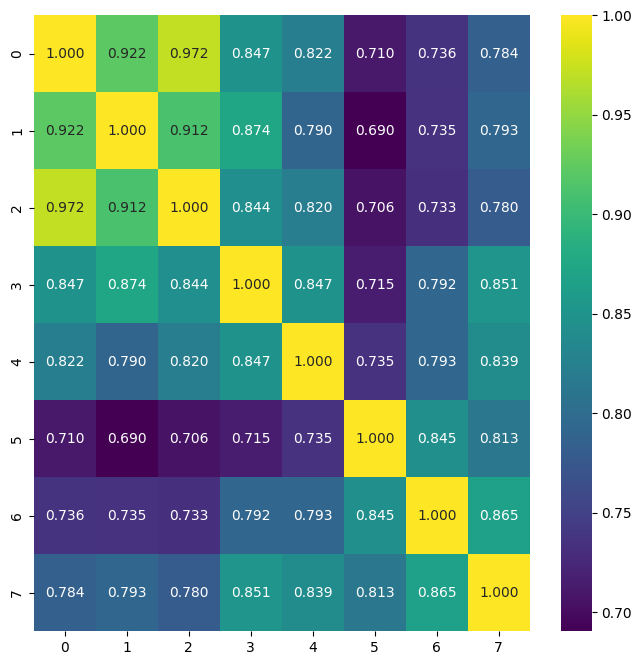

In [ ]:
embeddings_similarity_heatmap(openai_embeddings)

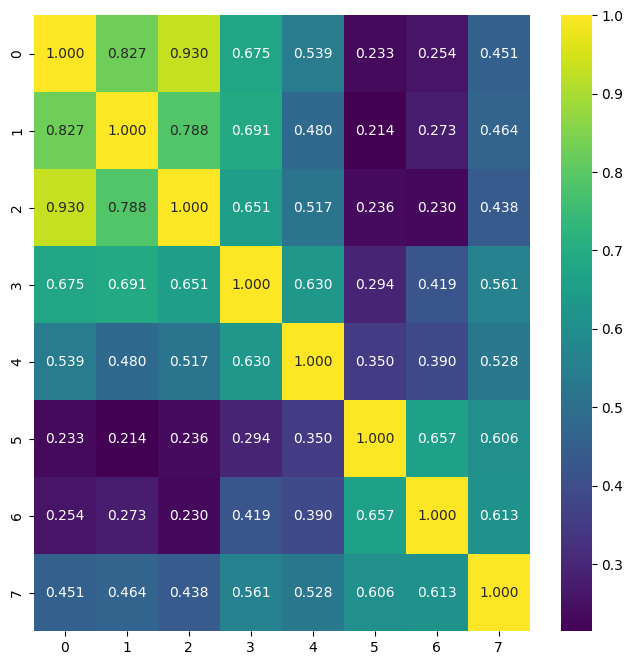

In [ ]:
embeddings_similarity_heatmap(cohere_embeddings)

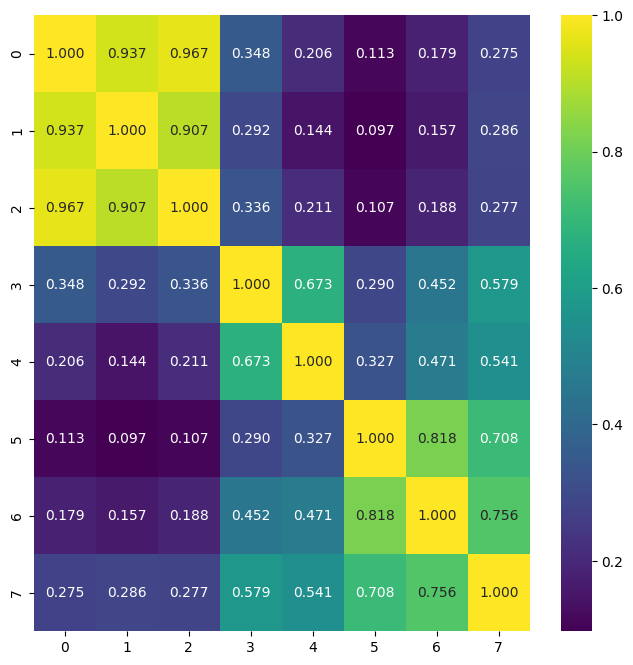

In [ ]:
embeddings_similarity_heatmap(sbert_embeddings)

## Multilingual

We use embeddings to capture semantic similarity.  What happens when we look at the same text in several languages.  Will our embeddings reflect the semantic similarity?

Let's examine "Mary had a little lamb" in English, French and Spanish.

In [ ]:
mary_english = """Mary had a little lamb,
Little lamb, little lamb,
Mary had a little lamb,
Its fleece was white as snow

Everywhere that Mary went,
Mary went, Mary went,
Everywhere that Mary went
The lamb was sure to go.

It followed her to school one day
School one day, school one day
It followed her to school one day
Which was against the rules.

It made the children laugh and play,
Laugh and play, laugh and play,
It made the children laugh and play
To see the lamb at school

And so the teacher turned it out,
Turned it out, turned it out,
And so the teacher turned it out,
But still it lingered near
"""

mary_french = """Mary avait un petit agneau,
Un petit agneau, un petit agneau,
Mary avait un petit agneau,
C'est toison était blanche comme neige, ouais

Partout, les Mary est allé,
Mary est allé, Mary est allé
Partout, les Mary est allé
Le petit agneau était sûr d'aller, ouais

Il la suivit à l'école un jour
A l'école un jour, à l'école un jour
Il la suivit à l'école un jour
Et enfreint la règle des enseignants.

Il a fait les enfants rient et jouent,
Rire et jouer, rire et jouer,
Il a fait les enfants rient et jouent
Pour voir un agneau à l'école

Et si l'enseignant il s'est avéré,
Il s'est avéré, il s'est avéré,
Et si l'enseignant il s'est avéré,
Mais toujours il resta près de
"""

mary_spanish = """Mary tenía un pequeño cordero,
Pequeño cordero, pequeño cordero
Mary tenía un pequeño cordero
Su lana era blanca como la nieve como la nieve blanca.

A cualquier lado que Mary iba
Mary iba, Mary iba
A cualquier lado que Mary iba
El cordero atrás yendo iba

Un día a la escuela la siguió
A la escuela un día, a la escuela un día
Un día a la escuela la siguió
Y eso estaba en contra de las reglas de la misma.

Hizó a los niños reír y jugar,
Reír y jugar, reír y jugar
Hizó a los niños reír y jugar
De verlo en la escuela estar.

Y entonces la maestra lo alejó,
Lo alejó, lo alejó
Y entonces la maestra lo alejó
Pero sin embargo cerca permanecía.
"""

mary = [mary_english, mary_french, mary_spanish]
mary_openai_embeddings = openai_embeddings_model.embed_documents(mary)
mary_cohere_embeddings = cohere_embeddings_model.embed_documents(mary)
mary_sbert_embeddings = sbert_embeddings_model.embed_documents(mary)

In [ ]:
[openai_token_count(string) for string in mary]

[143, 212, 218]

In [ ]:
[cohere_token_count(string) for string in mary]

[160, 284, 260]

In [ ]:
[sbert_token_count(string) for string in mary]

[145, 205, 168]

The OpenAI embeddings for the three renditions are similar.

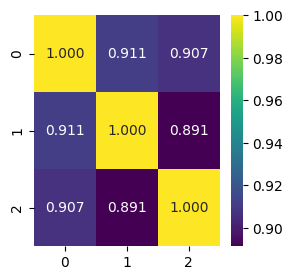

In [ ]:
embeddings_similarity_heatmap(mary_openai_embeddings)

The Cohere embeddings are not similar.  That's not surprising since it's an English only model.

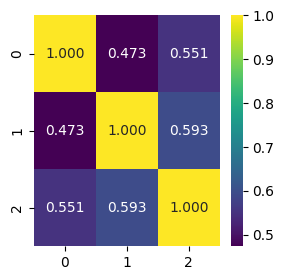

In [ ]:
embeddings_similarity_heatmap(mary_cohere_embeddings)

The Setence Transformer embeddings are similar and appear to be closer than the OpenAI embeddings.  This particular mode (`paraphrase-multilingual-mpnet-base-v2`) is a multilingual model.  This performance is not surprising.

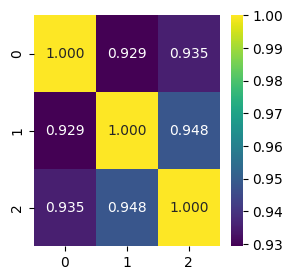

In [ ]:
embeddings_similarity_heatmap(mary_sbert_embeddings)

Cohere has a separate embedding model that provides multilingual embedding suport.  Unlike the `embed-english-v2.0` model which has a `512` token maximum, the `embed-multilingual-v2.0` model has a `256` token maximum.  See [Cohere multilingual language models](https://docs.cohere.com/docs/multilingual-language-models)

The Cohere multilingual model is much stronger on this example, but not as strong as the Sentence Transformer model we looked at above.

In [ ]:
cohere_multilingual_embeddings_model = CohereEmbeddings(
    model="embed-multilingual-v2.0", truncate="End"
)

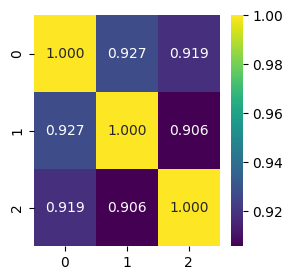

In [ ]:
mary_cohere_multilingual_embeddings = (
    cohere_multilingual_embeddings_model.embed_documents(mary)
)
embeddings_similarity_heatmap(mary_cohere_multilingual_embeddings)

Let's add "Three Blind Mice", in English and compare the OpenAI and Sentence Transformer multilingual embeddings.  Once again, while both seem to work, the Sentence Transformer embeddings seem better for this example.  The similar passagse are more tightly grouped and the outlier is further away.

In [ ]:
mice = """Three blind mice, three blind mice
See how they run, see how they run
They all run away from the farmer's wife
Then into a space ship to take a ride
Did you ever see such a sight in your life
As three blind mice?

Three blind mice, three blind mice
Crash on the moon, crash on the moon
The moon was covered in cheese so high
And nobody knew the reason why
Did you ever see such a sight in your life
As three blind mice?

Three blind mice, three blind mice
With full tummies, with full tummies
All of them ate too much cheese that night
With little moon left after every bite
Did you ever see such a sight in your life
As three blind mice?"""

In [ ]:
openai_token_count(mice)

159

In [ ]:
sbert_token_count(mice)

159

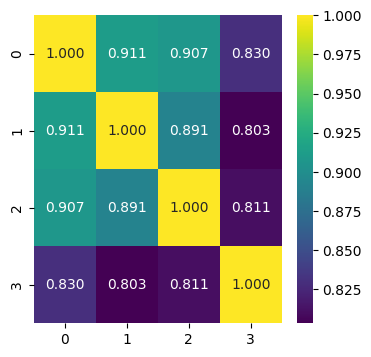

In [ ]:
mary_mice_openai_embeddings = openai_embeddings_model.embed_documents(mary + [mice])
embeddings_similarity_heatmap(mary_mice_openai_embeddings)

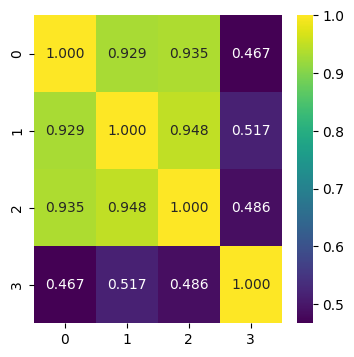

In [ ]:
mary_mice_sbert_embeddings = sbert_embeddings_model.embed_documents(mary + [mice])
embeddings_similarity_heatmap(mary_mice_sbert_embeddings)

What happens when we add some music lyrics to the mix?  As we have seen in the prior examples, the OpenAI embeddings don't seem to do as good a job at separating the examples as the Sentence Transformer embeddings do.

In [ ]:
bohemian = """I see a little silhouetto of a man
Scaramouche, Scaramouche, will you do the Fandango?
Thunderbolt and lightning, very, very frightening me
(Galileo) Galileo, (Galileo) Galileo, Galileo Figaro, magnifico
But I'm just a poor boy, nobody loves me
He's just a poor boy from a poor family
Spare him his life from this monstrosity"""

In [ ]:
openai_token_count(bohemian)

97

In [ ]:
sbert_token_count(bohemian)

94

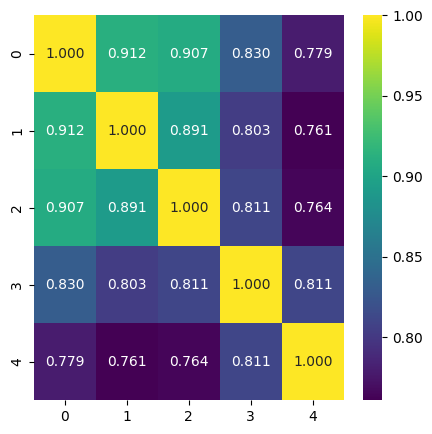

In [ ]:
amalgam_openai_embeddings = openai_embeddings_model.embed_documents(
    mary + [mice, bohemian]
)
embeddings_similarity_heatmap(amalgam_openai_embeddings)

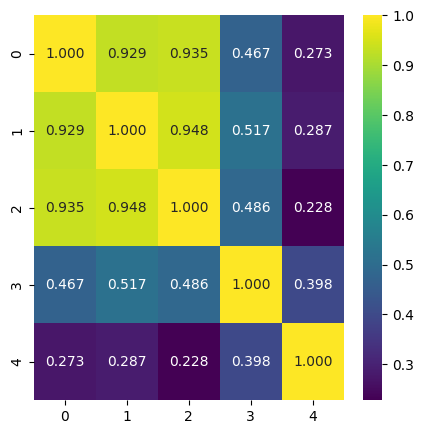

In [ ]:
amalgam_sbert_embeddings = sbert_embeddings_model.embed_documents(
    mary + [mice, bohemian]
)
embeddings_similarity_heatmap(amalgam_sbert_embeddings)

Let's pause before we move on to vector databases.  Our examples, while more than a sentence long, are still relatively short passages.  However, we often want to work with collections of text that are much longer than can be captured in an embedding.  Especially if the embedding capacity is on the lower end of the range.  The SBERT multilingual embeddings we looked at can only handle `128` tokens.  The Cohere multilingual embeddings get to `256` tokens and if we use the Cohere english only embeddings we get to `512`.  On the other hand, the OpenAI embeddings have a maximum context length of `8192` tokens.  The difference is dramatic.

If your text is short, you may not be concerned.  But if your text sequences are well beyond the capacity of your embedding model then you will need to consider the consequences.  Do you truncate your text because you believe the truncated part captures the essence of what you care about?  Will you split your text into chunks and hope that what you care about is captured in a single chunk and not split across several chunks?  If you go with large embeddings, do you think they will capture enough detail for your use?  These are all important considerations and your decisions will depend on your use case, the size of the passages you work with and the semantic complexity.

# Vector Databases

## Introduction

A vector database, also known as a vector search engine or similarity search database, is a type of database that specializes in storing and retrieving high-dimensional vectors efficiently.  The embeddings we have been using are high-dimensional vectors.

In the context of question answering tasks, vector databases can be particularly useful for tasks like semantic search, where you want to find documents or data points that are semantically similar to a given query.

Traditional relational databases are not well-suited for efficiently querying and retrieving semantically similar data. Vector databases, on the other hand, are designed to handle similarity-based searches efficiently.

Vector databases are an essential component of modern natural language processing solutions that are built to apply the generative capabilities of large language models to data collections.  This approach is called retrieval augmented generation or "RAG".

RAG is used in tasks like question answering.  With RAG, a retrieval component first selects a set of relevant documents or passages from a larger corpus, and then a generation component generates the final response based on the selected information. This approach aims to combine the accuracy of retrieval with the flexibility of generation.

We will use Qdrant, a vector database and explore some of the most important concepts.  For this notebook, we use an ephemeral vector database.  It is easy to swap in a persistent database.  Since our examples are easily built we don't bother.  For anything beyond toy examples, we would use a persistent database.

## Vector Database Embeddings

The choice of a generative large language model can be decoupled from the selection of the embedding model used in an accompanying vector database.  The models we have been using take a tokenized string as input and not an embedding.  When performing similarity search, you will want to use the same model for generating the embeddings as for turning the query into an embedding for use with the vector database.  Your goal will be to get the string representation of the embeddings returned from the vector database.  LangChain can pass back the results as strings inside LangChain document objects.

Up to this point we have experimented with several different embedding models.  For the remaining exercises, we will use a different embedding model.  We will use `multi-qa-mpnet-base-cos-v1` from the SentenceTransformer collection.  It is based on `microsoft/mpnet-base` and has a maximum token length of `512`.  The embeddings are normalized and cosine-similarity is an appropriate choice for a distance function.

OpenAI trial accounts expire after three months and provide access to `gpt-3.5-turbo` but not `gpt-4`.  Paid OpenAI accounts permit use of `gpt-4` as well and do not expire.  Cohere trial accounts do not expire, but the API rate limiting is more significant than OpenAI trial account rate limiting.

Set the `LLM` variable below to reflect the generative model you want to use.  

The results in most of the examples below will vary with your choice.


In [ ]:
# llm = Cohere(model="command", temperature=0)  ##Cohere seems fragile on self-query
LLM = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
# llm = ChatOpenAI(model="gpt-4", temperature=0)

In [ ]:
st_model_name = "multi-qa-mpnet-base-cos-v1"
st_embeddings_model = HuggingFaceEmbeddings(model_name=st_model_name)
st_tokenizer = AutoTokenizer.from_pretrained(f"sentence-transformers/{st_model_name}")

embeddings_model = st_embeddings_model

## Document Chunking

Document chunking, also known as text segmentation or document splitting, refers to the process of breaking down large documents or pieces of text into smaller, manageable segments before feeding them to large language models. There are several reasons why chunking is important when working with these models.

Chunking documents when working with large language models is essential to overcome input limitations, improve performance, manage costs, ensure complete responses, maintain contextual coherence, and guide the model's attention effectively. It allows you to make the most out of these powerful models when dealing with lengthy or complex text documents.

In the following code cells, we will download several corporate privay policies from the web.  We will use document loaders specific to `pdf` files or `urls` as the case may be.

We the use LangChain's `RecursiveCharacterTextSplitter` to chunk each document.  See the relevant [LangChain documentation](https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/recursive_text_splitter).

We add a piece of metadata that identifies the relevant organization for each chunk.

In [ ]:
install_if_needed(["pypdf", "unstructured"])

import textwrap
from langchain.document_loaders import PyPDFLoader, UnstructuredURLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.0/271.0 kB 4.7 MB/s eta 0:00:00
pypdf has been installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 33.4 MB/s eta 0:00:00
unstructured has been installed.


In [ ]:
import pandas as pd

policy_data = [
    ("Apple",
     "Privacy Policy",
     "https://www.apple.com/legal/privacy/pdfs/apple-privacy-policy-en-ww.pdf",
    ),
    ("Cohere", "Privacy Policy", "https://cohere.com/privacy"),
    ("Google",
     "Privacy Policy",
     "https://static.googleusercontent.com/media/www.google.com/en//intl/en/policies/privacy/google_privacy_policy_en.pdf",
    ),
    ("Hugging Face", "Privacy Policy", "https://huggingface.co/privacy"),
    ("Meta",
     "Privacy Policy",
     "https://about.fb.com/wp-content/uploads/2022/07/Privacy-Within-Metas-Integrity-Systems.pdf",
    ),
    ("Threads", "Privacy Policy", "https://terms.threads.com/privacy-policy"),
    ("TikTok",
     "Privacy Policy",
     "https://www.tiktok.com/legal/page/us/privacy-policy/en",
    ),]

columns = ["organization", "title", "url"]

policy_df = pd.DataFrame(policy_data, columns=columns)

In [ ]:
def get_chunks(url, organization, title, chunk_size=385, chunk_overlap=50):
    """
    This function takes a url to an organization's web page, organization name,
    and document title and returns chunks constructed from the target url.
    The function adds the url, the organization name and the document title
    as metadata to the chunks.

    Parameters:
    url (string): Target page.
    organization (string): Organization name.
    title: Document title.
    chunk_size (int, optional): Chunk size, default is 1000 characters.
    chunk_overlap (int, optional): Chunk overlap, default is 10 characters.

    Returns:
    list of chunks
    """

    # Use PyPDFLoader for pdf targets, otherwise UnstructuredURLLoader
    if os.path.splitext(url)[1] == ".pdf":
        loader = PyPDFLoader(url)
    else:
      loader = UnstructuredURLLoader([url])

    documents = loader.load()
    for document in documents:
        metadata = document.metadata
        metadata["url"] = url
        metadata["organization"] = organization
        metadata["title"] = title
        if metadata.get("page", None) is not None:
            metadata["page"] += 1

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

    return text_splitter.split_documents(documents)


def explore_documents(documents):
    block_indent = "   "
    metadata = documents[0].metadata
    content = documents[0].page_content
    print(f"{metadata['organization']} {metadata['title']} {len(documents)} chunks")
    print("First chunk:")
    print(
        textwrap.fill(
            content,
            initial_indent=block_indent,
            subsequent_indent=block_indent,
            replace_whitespace=True,
        )
    )
    print()

In [ ]:
chunks = []

for row in policy_df.itertuples(index=False):
    policy_chunks = get_chunks(row.url, row.organization, row.title)
    explore_documents(policy_chunks)
    chunks += policy_chunks

Apple Privacy Policy 79 chunks
First chunk:
   Apple Privacy Policy Apple’s Privacy Policy describes how Apple
   collects, uses, and shares your personal data. Updated December 22,
   2022 In addition to this Privacy Policy, we provide data and
   privacy information embedded in our products and certain features
   that ask to use your personal data. This product-specific
   information is accompanied by our Data & Privacy Icon.  You will be

Cohere Privacy Policy 57 chunks
First chunk:
   Products  For Developers  For Business  Pricing  Blog  Company  Try
   now  Cohere Privacy Policy  Last Update: Aug 4, 2023

Google Privacy Policy 82 chunks
First chunk:
   Privacy Policy Last modified: December 18, 2017 ( view archived
   versions ) (The hyperlinked examples are available at the end of
   this document.) There are many different ways you can use our
   services – to search for and share information, to communicate with
   other

Hugging Face Privacy Policy 66 chunks
First chunk:
  

## Create Vector Database from Chunked Documents

In [ ]:
install_if_needed("qdrant-client")
from langchain.vectorstores import Qdrant

qdrant-client has been installed.


In [ ]:
print (f"There are {len(chunks)} chunks.")

There are 654 chunks.


In [ ]:
# Let's take a look at a few chunks.

chunks[22]

Document(page_content='a government-issued ID in limited circumstances, including when setting up a wireless account and activating your device, for the purpose of extending commercial credit, managing reservations, or as required by law •Other Information You Provide to Us. Details such as the content of your communications with Apple, including interactions with customer support and contacts through', metadata={'source': '/tmp/tmprrka5pu9/tmp.pdf', 'page': 4, 'url': 'https://www.apple.com/legal/privacy/pdfs/apple-privacy-policy-en-ww.pdf', 'organization': 'Apple', 'title': 'Privacy Policy'})

In [ ]:
chunks[356]

Document(page_content='know whether or not adult nudity and sexual activity was consensually taken and consensually \n shared on our platforms. \n One way we can account for this lack of knowledge, however, is by using automation to remove \n all forms of adult nudity that violate Community Standards on Instagram and Facebook. In this', metadata={'source': '/tmp/tmpaijjvjfe/tmp.pdf', 'page': 12, 'url': 'https://about.fb.com/wp-content/uploads/2022/07/Privacy-Within-Metas-Integrity-Systems.pdf', 'organization': 'Meta', 'title': 'Privacy Policy'})

In [ ]:
chunks[600]

Document(page_content='and Stripe (https://stripe.com/en-ie/privacy).', metadata={'source': 'https://www.tiktok.com/legal/page/us/privacy-policy/en', 'url': 'https://www.tiktok.com/legal/page/us/privacy-policy/en', 'organization': 'TikTok', 'title': 'Privacy Policy'})

In [ ]:
%%time

collection_name = "my_collection"

vectordb = Qdrant.from_documents(
    documents = chunks,
    embedding = embeddings_model,
    location = ":memory:",
    collection_name = collection_name
    )

CPU times: user 1.88 s, sys: 38.4 ms, total: 1.92 s
Wall time: 1.02 s


In [ ]:
# Confirm that we have the same number of vectors in the vector database as we have chunks.

assert vectordb.client.get_collection(collection_name).vectors_count == len(chunks)

## Query the Vector Database

A similarity search that returns the four vectors closest to the query by default.

In [ ]:
query = "Does Apple sell my personal data?"
results = vectordb.similarity_search(query)
[result.metadata["organization"] for result in results]

['Apple', 'Apple', 'Apple', 'Apple']

Examine the first result in the list.  It looks to be responsive to the question.

In [ ]:
print(textwrap.fill(results[0].page_content))

also disclose information about you where there is a lawful basis for
doing so, if we determine that disclosure is reasonably necessary to
enforce our terms and conditions or to protect our operations or
users, or in the event of a reorganization, merger, or sale. Apple
does not sell your personal data including as “sale” is defined in
Nevada and California. Apple also does not


Increase the number of results to 10.  The results are not limited to information that came from Apple's policy.

In [ ]:
query = "Does Apple sell my personal data?"
results = vectordb.similarity_search(query, k=10)
[result.metadata["organization"] for result in results]

['Apple',
 'Apple',
 'Apple',
 'Apple',
 'Threads',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple']

Let's take a look at each non-Apple result and see what's going on.

In [ ]:
for result in results:
  if result.metadata["organization"] != "Apple":
    print(f"Organization: {result.metadata['organization']}")
    print(textwrap.fill(result.page_content))
    print()

Organization: Threads
Personal Data Sales  We will not sell your Personal Data, and have not
done so over the last 12 months.  Personal Data Sharing



The embedding doesn't say anything about Apple but it does talk about the sale of personal data.  So, while the result wasn't in the top few results, our similarity search brought in information we probably didn't want to consider.  Let's try another example.

In [ ]:
query = "Does Apple use cookies?"
results = vectordb.similarity_search(query, k=10)
[result.metadata["organization"] for result in results]

['Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Threads',
 'Threads',
 'Hugging Face']

We see the same issue.  Let's inspect.

In [ ]:
for result in results:
  if result.metadata["organization"] != "Apple":
    print(f"Organization: {result.metadata['organization']}")
    print(textwrap.fill(result.page_content))
    print()

Organization: Threads
You can learn more about our use of Cookies on our Cookie Policy.
Data Security

Organization: Threads
Cookies are small pieces of data– usually text files – placed on your
computer, tablet, phone or similar device when you use that device to
access Threads. We may also supplement the information we collect from
you with information received from third parties, including third
parties that have placed their own Cookies on your device(s). Please
note that because of our use of

Organization: Hugging Face
D. Cookies  We use cookies only for the purposes of delivering,
updating, monitoring, improving the Services, and maintaining security
on our Services by detecting, preventing and responding to any type of
threats or incidents.



None of these results reference Apple and they all talk about the use of cookies.  While it is true that we only saw these results by expanding the number of results return, this problem could show up when looking for fewer results.  For example, what if the cmopany we care about doesn't reference a concept at all and others do?

When we processed the source documents and split them into chunks, we added the name of the organization for the policy as metadata.  We can use that metadata as a filter.  In our example below, the filter is very simple, we merely indicate that the organization field needs to be `Apple`.  When we add that parameter, the results are limited to Apple embeddings.

In [ ]:
results = vectordb.similarity_search(query, filter={"organization": "Apple"}, k=10)
[result.metadata["organization"] for result in results]

['Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple']

Our next query only references "the company" and not any specific company.  The results relate to several of the companies.

In [ ]:
query = "Does the company sell private data?"
results = vectordb.similarity_search(query, k=10)
[result.metadata["organization"] for result in results]

['Threads',
 'Threads',
 'Apple',
 'Apple',
 'Threads',
 'Threads',
 'Hugging Face',
 'Cohere',
 'TikTok',
 'Apple']

We can use the filter to indicate that we care about Google only.

In [ ]:
query = "Does the company sell private data?"
results = vectordb.similarity_search(query, filter={"organization": "Google"}, k=10)
[result.metadata["organization"] for result in results]

['Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google']

In [ ]:
print(textwrap.fill(results[0].page_content))

by law. We may share  non-personally identifiable information
publicly and with our partners – like publishers, advertisers or
connected sites. For example, we may share information publicly to
show trends  about the general use of our services. If Google is
involved in a merger, acquisition or asset sale, we will continue to
ensure the confidentiality of any personal


# Answering Questions With Retrieval Augmented Generation

Now that we have some familiarity with vector databases, let's use ours, together with a large language model, to answer questions about the five privacy policies we have been working with.  We will continue to rely on the LangChain framework.

## Prompting a Model

Before we introduce working with the vector database, let's experiment with some simple model prompts.  We will pass a string to Cohere's `command` model, which is its default generative model, and see how it responds.  We will do the same thing with OpenAI's `chatgpt-3.5`.

The responses are based on information the model was trained on.  We don't know if it they are accurate.  Sources are not presented.  The Cohere response for Threads doesn't seem to relate to the Threads social media platform and the OpenAI model isn't able to fine Threads information.

In [ ]:
from langchain.schema import HumanMessage

cohere_llm = Cohere(model="command", temperature=0)
openai_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [ ]:
query = "Does Apple sell my personal data?"
result = cohere_llm(query)
print(textwrap.fill(result.strip()))

Apple has a strong commitment to protecting the privacy of its
customers. The company does not sell personal data to third parties.
However, it does collect and use data to provide services and improve
products.  For example, Apple collects data about how people use their
devices, such as which apps are used and how often. This data is used
to improve the user experience and develop new features.  Apple also
collects data about customers' purchasing habits, which is used to
improve marketing and develop new products.  In addition, Apple
collects data about customers' location, which is used to provide
location-based services and improve maps.  Apple's commitment to
privacy is a key selling point for many customers. The company's
privacy policies are designed to protect customers' personal data and
ensure that it is used only for legitimate purposes.


In [ ]:
query = "Does Threads sell my personal data?"
result = cohere_llm(query)
print(textwrap.fill(result.strip()))

Threads does not sell your personal data. We are committed to
protecting your privacy and will never share your personal information
with third parties without your permission.  We may collect and use
your personal information for the following purposes:  - To provide
you with the services you request - To improve our services and
products - To communicate with you about our services and products -
To protect our rights and property - To comply with legal obligations
We will never share your personal information with third parties
without your permission, except as required by law. We will never sell
your personal information to third parties.  If you have any questions
or concerns about how we use your personal information, please contact
us at support@threadscanada.com.


In [ ]:
messages = [HumanMessage(content="Does Apple sell my personal data?")]
print(textwrap.fill(openai_llm(messages).content))

Apple has a strong commitment to privacy and has stated that it does
not sell personal data to third parties. Apple's business model
primarily relies on selling hardware, software, and services rather
than monetizing user data. However, it is important to note that Apple
does collect and use certain user data for various purposes, such as
improving its products and services, but it is typically anonymized
and aggregated to protect user privacy.


In [ ]:
messages = [HumanMessage(content="Does Threads sell my personal data?")]
print(textwrap.fill(openai_llm(messages).content))

As an AI language model, I don't have access to specific company
policies or practices. However, it is important to note that I am
developed by OpenAI and designed to respect user privacy and
confidentiality. My primary function is to provide information and
answer questions to the best of my knowledge and abilities. If you
have concerns about the data practices of a specific company like
Threads, it is recommended to review their privacy policy or contact
them directly for accurate information.


## LangChain PromptTemplate

A prompt template is a reproducible way to generate prompts. It's essentially a text string that can take in a set of parameters from the end user and generate a prompt accordingly.  Let's shift to LangChain chains by using the simplest of templates.  In these examples, we use the large language model you selected above.  Remember, the model is generating responses based on its training data.

In [ ]:
from langchain import PromptTemplate, LLMChain

In [ ]:
template = """Question: {question} Answer:"""
prompt = PromptTemplate(template=template, input_variables=["question"])

chain = LLMChain(prompt=prompt, llm=LLM)

Let's inspect the prompt included inside the chain.

In [ ]:
chain.prompt

PromptTemplate(input_variables=['question'], output_parser=None, partial_variables={}, template='Question: {question} Answer:', template_format='f-string', validate_template=True)

In [ ]:
query = "Does Apple sell my personal data?"
print(textwrap.fill(chain.run(query)).strip())

No, Apple does not sell your personal data. Apple has a strong
commitment to privacy and has implemented various measures to protect
user data.


In [ ]:
query = "Does Threads sell my personal data?"
print(textwrap.fill(chain.run(query)).strip())

No, Threads does not sell your personal data.


## LangChain RetrievalQA Chain

Now we introduce our vector database and the LangChain Retrieval QA chain, a chain for question answering against a database of information.  We will also supply our own prompt. It would be reassuring if sources were identified.

In [ ]:
from langchain.chains import RetrievalQA

In [ ]:
template = """Use the following pieces of context to answer the question at the end.
Your answer should be as concise as possible and ideally not more than one sentence.
If you don't know the answer, just say that you don't know.

{context}

Question: {question}

Answer:"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

chain = RetrievalQA.from_chain_type(
    LLM, retriever=vectordb.as_retriever(), chain_type_kwargs={"prompt": prompt}
)

Before we call the chain, let's inspect our template and the retriever it includes.

In [ ]:
print(chain.combine_documents_chain.llm_chain.prompt.template)

Use the following pieces of context to answer the question at the end.
Your answer should be as concise as possible and ideally not more than one sentence.
If you don't know the answer, just say that you don't know.

{context}

Question: {question}

Answer:


In [ ]:
chain.retriever

VectorStoreRetriever(tags=['Qdrant', 'HuggingFaceEmbeddings'], metadata=None, vectorstore=<langchain.vectorstores.qdrant.Qdrant object at 0x7d0d1d2ed030>, search_type='similarity', search_kwargs={})

In [ ]:
query = "Does Apple sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

No, Apple does not sell your personal data.


In [ ]:
query = "Does TikTok sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

No.


Let's use the same prompt and get source documents too.

In [ ]:
chain = RetrievalQA.from_chain_type(
    llm=LLM,
    retriever=vectordb.as_retriever(),
    chain_type_kwargs={"prompt": prompt},
    return_source_documents=True,
)

In [ ]:
query = "Does Apple sell my personal data?"
result = chain(query)

Now, instead of returning a string, the result is a dictionary with three keys, `query`, `result` and `source_documents`.

In [ ]:
result.keys()

dict_keys(['query', 'result', 'source_documents'])

In [ ]:
print(textwrap.fill(result["result"].strip()))

No, Apple does not sell your personal data.


Let's examine the `organization` field for the source documents from that result.

In [ ]:
[source.metadata["organization"] for source in result["source_documents"]]

['Apple', 'Apple', 'Apple', 'Apple']

Let's ask a general question and then say we only care about Apple and Hugging Face.  

In [ ]:
query = "Do companies use cookies?  I only care about Apple and Hugging Face."
result = chain(query)

In [ ]:
print(textwrap.fill(result["result"].strip()))

Yes, both Apple and Hugging Face use cookies.


In [ ]:
[source.metadata["organization"] for source in result["source_documents"]]

['Apple', 'Apple', 'Apple', 'Hugging Face']

Let's ask about Microsoft.  Remember, we have not loaded the Microsoft policy.  Notice that we get an answer about Microsoft, which must be based on the model's training data.  Also, our answer about Cohere isn't based on the source documents listed.

In [ ]:
query = "Do companies use cookies?  I only care about Apple, Cohere and Microsoft."
result = chain(query)

In [ ]:
print(textwrap.fill(result["result"].strip()))

Yes, companies use cookies, including Apple, Cohere, and Microsoft.


In [ ]:
[source.metadata["organization"] for source in result["source_documents"]]

['Apple', 'Apple', 'Hugging Face', 'Threads']

Self-querying retriever.

A self-querying retriever is one that, as the name suggests, has the ability to query itself. Specifically, given any natural language query, the retriever uses a query-constructing LLM chain to write a structured query and then applies that structured query to it's underlying vectorstore. This allows the retriever to not only use the user-input query for semantic similarity comparison with the contents of stored documented, but to also extract filters from the user query on the metadata of stored documents and to execute those filters.

The self-querying retriever's arguments include descriptions of the metadata fields and the document content.

In [ ]:
# install_if_needed("lark")

lark is already installed.


In [ ]:
# !pip uninstall --yes lark
!pip install lark-parser

In [ ]:
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

metadata_field_info = [
    AttributeInfo(
        name="organization",
        description="The company or organization that created the document.  It describes that company's policy.",
        type="string or list[string]",
    ),
    AttributeInfo(
        name="title",
        description="The title of the document",
        type="string",
    ),
    AttributeInfo(
        name="url",
        description="The url for the document",
        type="string",
    ),
]
document_content_description = "A policy"

retriever = SelfQueryRetriever.from_llm(
    LLM,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True,
    enable_limit=True,
)

NameError: ignored

In [ ]:
import lark

We will use the `get_relevant_documents` method provided by the `SelfQueryRetriever` class and examine both the metadata filter generated and the organization for the relevant documents retrieved.

As you look at the examples below and substitute your own you should discover that the approach is not consistent reliable.  In some cases, the system seems to fail to understand that a word in a query is an organization.  Sometimes revising the prompt a little bit to make that distinction more apparent helps.

Does this suggest that using our generative models to do entity extraction is perhaps not the best way to proceed?

In the next example, the system does not identify Meta as an organization.  Nevertheless, it is interesting to note that three of the four examples relate to Meta and the first example, is about one of Meta's businesses, Threads.

In [ ]:
documents = retriever.get_relevant_documents("How does Meta protect my data?")
[document.metadata["organization"] for document in documents]

query='Meta protect my data' filter=None limit=None


['Threads', 'Meta', 'Meta', 'Meta']

However, when we change the query to make more explicit that we are talking about the company named Meta, the filter we want is generated and the documents are limited to Meta.

In [ ]:
documents = retriever.get_relevant_documents("How does the company named Meta protect my data?")
[document.metadata["organization"] for document in documents]

query='Meta data protection' filter=Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Meta') limit=None


['Meta', 'Meta', 'Meta', 'Meta']

One of the subtle and even more interesting things about LangChain's self query retriever is that we can use it to allow the query to specify the number of documents to fetch.  We did that by passing `enable_limit=True` to the constructor.  See the relevant documentation [here](https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/qdrant_self_query).

In the next example, the prompt asks for five examples, the query has `limit=5` and we get five results instead of the default of four.

In [ ]:
documents = retriever.get_relevant_documents("How does the company named Meta protect my data? I want five examples.")
[document.metadata["organization"] for document in documents]

query='Meta protect my data' filter=Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Meta') limit=5


['Meta', 'Meta', 'Meta', 'Meta', 'Meta']

But we don't know if the relevant documents say the same thing.  Let's take a look.

In [ ]:
for document in documents:
  print (textwrap.fill(document.page_content))
  print()

experiences for people online where they feel free to connect and
share. We believe that   protecting people’s privacy is key to
creating positive experiences across Meta products and   services
because people want to know that their information is used and handled
appropriately.   But how we approach privacy in safety and security
product design is informed by the context

July 2022   Privacy within Meta’s   Integrity Systems   Why user
rights are at the center   of our safety and security approach

with others and other information you provide when you use Meta
products, including when you   sign up for an account.  30  The data
we use for integrity  purposes can include metadata, such as   the
location of a photo or the date a file was created; information about
your device or network

Privacy is a core value in safety and security enforcement.  5   Meta
is committed to reducing bad experiences on our services.  5   The
regulatory environment for privacy, free speech, and safety is


Those responses seem reasonably distinct.  But what if they were too similar?  This is where the concept of maximum marginal relevance ("MMR") is useful.  MMR is used to diversify the results returned by a search algorithm by selecting items that are both relevant to a query and different from each other.  A discussion of MMR is beyond the scope of this notebook.  Moreover, the set of documents we have included consist of single policy from each organization and there is relatively little redundancy.

Now, let's ask about two companies.  The filter seems to be doing the right thing.  However, the set of documents returned is limited to just one of the companies. Maybe that is ok since our question asks if either organization uses cookies.

In [ ]:
documents = retriever.get_relevant_documents("Do Apple or Microsoft use cookies?")
[document.metadata["organization"] for document in documents]

query='cookies' filter=Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Apple'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Microsoft')]) limit=None


['Apple', 'Apple', 'Apple', 'Apple']

But when we ask specifically about each company in a single query, the system only retrieves documents about Apple as being relevant.  This is hard.  Our vector database stores information about single documents, none of which reference other companies (ignoring that Threads is a Meta business).  We need a more sophisticated approach.

In [ ]:
documents = retriever.get_relevant_documents("Does Apple use cookies?  Does Microsoft use cookies?")
[document.metadata["organization"] for document in documents]

query='cookies' filter=Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Apple'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Microsoft')]) limit=None


['Apple', 'Apple', 'Apple', 'Apple']

Up to this point we have not included prompts that looked to exclude information.  Let's try some below.  

In the first example, we get responses related to Threads, TikTok and Apple.

In [ ]:
documents = retriever.get_relevant_documents("How do companies protect my data.")
[document.metadata["organization"] for document in documents]

query='data protection' filter=None limit=None


['Threads', 'TikTok', 'Apple', 'Threads']

Now we revise the prompt to exclude Threads.

In [ ]:
documents = retriever.get_relevant_documents("How do companies protect my data.  I am not interested in information about Threads.")
[document.metadata["organization"] for document in documents]

query='data protection' filter=Operation(operator=<Operator.NOT: 'not'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Threads')]) limit=None


['TikTok', 'Apple', 'Apple', 'Google']

Finally, we revise the prompt to exclude both Threads and Apple.

In [ ]:
documents = retriever.get_relevant_documents("How do companies protect my data.  I do not care about Threads or Apple.")
[document.metadata["organization"] for document in documents]

query='data protection' filter=Operation(operator=<Operator.NOT: 'not'>, arguments=[Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Threads'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Apple')])]) limit=None


['TikTok', 'Google', 'Meta', 'Meta']

If you experiment with the self query mechanism you will likely conclude that it is fragile.  The implementations seem to vary by vector database as well.  For example, when this notebook was created, Chroma, a popular vector database for simple LangChain examples, does not support self query operations that result in the use of the `NOT` operator even though the query parser recognizes when that operator should be used and Chroma supports that operator directly.